### Average sigmoid

The idea - what if we do not need any model, and as the filtered data are already sigmoid, 
can we use some average sigmoid parameters = some averaged values for all the data
1. mean parameters from the training data and apply them to test data:
    - original train and test data with 11 drugs
    - reduced datasets with 10 drugs
2. make a new dataset a find sigmoid parameters by scipy curve fitting

In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
def sigmoid_4_param(x, x0, L, k, d):
    """ Comparing with Dennis Wang's sigmoid:
    x0 -  p - position, correlation with IC50 or EC50
        bounds [0, 1]
    L = 1 in Dennis Wang's sigmoid, protect from devision by zero if x is too small 
        L<1 inverted sigmoid, l=100 - lower upper and lower boundso sigmpoid on y axis (y= [0.1, 0.11])
        bounds [0.8, 10]
    k = -1/s (s -shape parameter)  default = -10 k=0 straight line, k<0 sigmoid around k=-10
        bounds [1, -100]
    d - determines the vertical position of the sigmoid - shift on y axis - better fitting then Dennis Wang's sigmoid
         bounds [0, 0.9]
    parameters_bound ((0, 0.8, -100, 0), (1, 10, 1, 0.9))
    """
    return ( 1/ (L + np.exp(-k*(x-x0))) + d)

def r2_score_sigmoid_4_param(df, x_columns, y_columns, param_columns = []):
    r2_scores=np.zeros(len(df.index))
    for i in range(len(df.index)):
        x = df.loc[df.index[i], x_columns].values.astype(np.float32)
        y = df.loc[df.index[i], y_columns].values.astype(np.float32)
        fit_param = df.loc[df.index[i], param_columns].values.astype(np.float32)
#         print(fit_param)
        y_fit = sigmoid_4_param(x, *fit_param)
        r2_scores[i] = r2_score(y, y_fit)
    return r2_scores

### 1. Finding a mean among fitted parameters on the original data

In [3]:
_FOLDER2 ="results/"

with open(_FOLDER2 + "drug_ids_50.txt", 'r') as f:
    drug_ids_50 = [np.int32(line.rstrip('\n')) for line in f]

train_df = pd.read_csv(_FOLDER2+"train08_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
test_df = pd.read_csv(_FOLDER2+"test02_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)               

train_df_50 = train_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()
test_df_50 = test_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()

test_df_50["mean_param_1_df4"] = train_df_50["param_1"].mean() 
test_df_50["mean_param_2_df4"] = train_df_50["param_2"].mean() 
test_df_50["mean_param_3_df4"] = train_df_50["param_3"].mean() 
test_df_50["mean_param_4_df4"] = train_df_50["param_4"].mean() 

test_df_50["abs_error_param_1_df4"]= abs(test_df_50["param_1"] - test_df_50["mean_param_1_df4"])
test_df_50["abs_error_param_2_df4"]= abs(test_df_50["param_2"] - test_df_50["mean_param_2_df4"])
test_df_50["abs_error_param_3_df4"]= abs(test_df_50["param_3"] - test_df_50["mean_param_3_df4"])
test_df_50["abs_error_param_4_df4"]= abs(test_df_50["param_4"] - test_df_50["mean_param_4_df4"])

test_df_50["r2_scores_df4"] = r2_score_sigmoid_4_param(test_df_50.reset_index(), 
                                                   x_columns = ["fd_num_"+str(i) for i in range(10)],
                                                  y_columns = ["norm_cells_" + str(i) for i in range(10)],
                                                  param_columns = ["mean_param_" + str(i)+"_df4" for i in range(1,5)])

# Distribution of mean parameter trained drug-by-drug 
print("\nDistribution of mean errors for an average sigmoid fitted original data\n")
i = 1 
print("MAE of parameter %d: %0.3f +/- %0.3f" % (i, test_df_50["abs_error_param_" + str(i) +"_df4"].mean(),
                                                test_df_50["abs_error_param_" + str(i) +"_df4"].std()))
i = 2 
print("MAE of parameter %d: %0.3f +/- %0.3f" % (i, test_df_50["abs_error_param_" + str(i) +"_df4"].mean(),
                                                test_df_50["abs_error_param_" + str(i) +"_df4"].std()))
i = 3 
print("MAE of parameter %d: %0.3f +/- %0.3f" % (i, test_df_50["abs_error_param_" + str(i) +"_df4"].mean(),
                                                test_df_50["abs_error_param_" + str(i) +"_df4"].std()))
i = 4 
print("MAE of parameter %d: %0.3f +/- %0.3f" % (i, test_df_50["abs_error_param_" + str(i) +"_df4"].mean(),
                                                test_df_50["abs_error_param_" + str(i) +"_df4"].std()))

print("R2 score: %0.3f +/- %0.3f" % (test_df_50["r2_scores_df4"].mean(),
                                    test_df_50["r2_scores_df4"].std()))


Distribution of mean errors for an average sigmoid fitted original data

MAE of parameter 1: 0.308 +/- 1.193
MAE of parameter 2: 0.331 +/- 1.564
MAE of parameter 3: 10.779 +/- 20.932
MAE of parameter 4: 0.089 +/- 0.091
R2 score: -0.001 +/- 0.666


In [4]:
import seaborn as sns

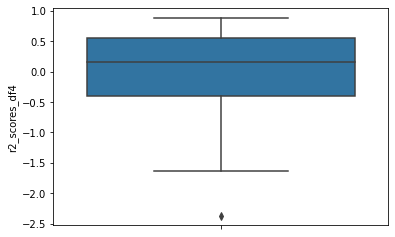

In [5]:
sns.boxplot(y="r2_scores_df4", data = test_df_50);

In [6]:
test_df_50[test_df_50["r2_scores_df4"] < 0].shape[0], test_df_50.shape[0]

(86, 202)

### 2. Finding a mean among fitted parameters on the reduced data

In [7]:
with open(_FOLDER2 + "drugs10_more_50.txt", 'r') as f:
    drug_ids_50 = [np.int32(line.rstrip('\n')) for line in f]

train_df = pd.read_csv(_FOLDER2+"2_train08_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
test_df = pd.read_csv(_FOLDER2+"2_test02_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)               

train_df_50 = train_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()
test_df_50 = test_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()

test_df_50["mean_param_1_df4"] = train_df_50["param_1"].mean() 
test_df_50["mean_param_2_df4"] = train_df_50["param_2"].mean() 
test_df_50["mean_param_3_df4"] = train_df_50["param_3"].mean() 
test_df_50["mean_param_4_df4"] = train_df_50["param_4"].mean() 

test_df_50["abs_error_param_1_df4"]= abs(test_df_50["param_1"] - test_df_50["mean_param_1_df4"])
test_df_50["abs_error_param_2_df4"]= abs(test_df_50["param_2"] - test_df_50["mean_param_2_df4"])
test_df_50["abs_error_param_3_df4"]= abs(test_df_50["param_3"] - test_df_50["mean_param_3_df4"])
test_df_50["abs_error_param_4_df4"]= abs(test_df_50["param_4"] - test_df_50["mean_param_4_df4"])

test_df_50["r2_scores_df4"] = r2_score_sigmoid_4_param(test_df_50.reset_index(), 
                                                   x_columns = ["fd_num_"+str(i) for i in range(10)],
                                                  y_columns = ["norm_cells_" + str(i) for i in range(10)],
                                                  param_columns = ["mean_param_" + str(i)+"_df4" for i in range(1,5)])

# Distribution of mean parameter trained drug-by-drug 
print("\nDistribution of mean errors for an average sigmoid fitted the REDUCED data\n")

i = 1 
print("MAE of parameter %d: %0.3f +/- %0.3f" % (i, test_df_50["abs_error_param_" + str(i) +"_df4"].mean(),
                                                test_df_50["abs_error_param_" + str(i) +"_df4"].std()))
i = 2 
print("MAE of parameter %d: %0.3f +/- %0.3f" % (i, test_df_50["abs_error_param_" + str(i) +"_df4"].mean(),
                                                test_df_50["abs_error_param_" + str(i) +"_df4"].std()))
i = 3 
print("MAE of parameter %d: %0.3f +/- %0.3f" % (i, test_df_50["abs_error_param_" + str(i) +"_df4"].mean(),
                                                test_df_50["abs_error_param_" + str(i) +"_df4"].std()))
i = 4 
print("MAE of parameter %d: %0.3f +/- %0.3f" % (i, test_df_50["abs_error_param_" + str(i) +"_df4"].mean(),
                                                test_df_50["abs_error_param_" + str(i) +"_df4"].std()))

print("R2 score: %0.3f +/- %0.3f" % (test_df_50["r2_scores_df4"].mean(),
                                    test_df_50["r2_scores_df4"].std()))


Distribution of mean errors for an average sigmoid fitted the REDUCED data

MAE of parameter 1: 0.115 +/- 0.073
MAE of parameter 2: 0.120 +/- 0.113
MAE of parameter 3: 11.831 +/- 24.778
MAE of parameter 4: 0.088 +/- 0.070
R2 score: 0.698 +/- 0.287


### 3. Making a long dataset and scipy curve fitting for the REDUCED data

In [8]:
df_concat = pd.DataFrame()
for i in range(10):
    df_concat = pd.concat([df_concat, train_df_50[["fd_num_"+str(i), "norm_cells_"+str(i)]].rename(
                                    columns={"fd_num_"+str(i): "scaled_x", 
                                             "norm_cells_"+str(i): "norm_y"})],
                          axis=0, ignore_index = True)
    
df_concat.shape, train_df_50.shape, df_concat.head()

((7280, 2),
 (728, 1379),
    scaled_x  norm_y
 0       0.0     1.0
 1       0.0     1.0
 2       0.0     1.0
 3       0.0     1.0
 4       0.0     1.0)

In [9]:
from scipy.optimize import curve_fit

In [11]:
def sigmoid_4_param(x, x0, L, k, d):
    """ Comparing with Dennis Wang's sigmoid:
    x0 -  p - position, correlation with IC50 or EC50
        bounds [0, 1]
    L = 1 in Dennis Wang's sigmoid, protect from devision by zero if x is too small 
        L<1 inverted sigmoid, l=100 - lower upper and lower boundso sigmpoid on y axis (y= [0.1, 0.11])
        bounds [0.8, 10]
    k = -1/s (s -shape parameter)  default = -10 k=0 straight line, k<0 sigmoid around k=-10
        bounds [1, -100]
    d - determines the vertical position of the sigmoid - shift on y axis - better fitting then Dennis Wang's sigmoid
         bounds [0, 0.9]
    parameters_bound ((0, 0.8, -100, 0), (1, 10, 1, 0.9))
    """
    return ( 1/ (L + np.exp(-k*(x-x0))) + d)

fitting_function = sigmoid_4_param
x = df_concat["scaled_x"]
y = df_concat["norm_y"]
# parameters_guess = [0.4, 1.0, 1.0, .0]
parameters_guess = [0.4, 1.0, -10, .0]
parameters, p_covariance = curve_fit(fitting_function, x, y, parameters_guess)

In [12]:
parameters

array([ 0.44071795,  1.03771175, -7.73694224,  0.07216926])

In [19]:
test_df_50["fit_param_1_df4"] = parameters[0]
test_df_50["fit_param_2_df4"] = parameters[1]
test_df_50["fit_param_3_df4"] = parameters[2]
test_df_50["fit_param_4_df4"] = parameters[3]

test_df_50["abs_error_param_1_df4"]= abs(test_df_50["param_1"] - test_df_50["fit_param_1_df4"])
test_df_50["abs_error_param_2_df4"]= abs(test_df_50["param_2"] - test_df_50["fit_param_2_df4"])
test_df_50["abs_error_param_3_df4"]= abs(test_df_50["param_3"] - test_df_50["fit_param_3_df4"])
test_df_50["abs_error_param_4_df4"]= abs(test_df_50["param_4"] - test_df_50["fit_param_4_df4"])

test_df_50["r2_scores_df4"] = r2_score_sigmoid_4_param(test_df_50.reset_index(), 
                                                   x_columns = ["fd_num_"+str(i) for i in range(10)],
                                                  y_columns = ["norm_cells_" + str(i) for i in range(10)],
                                                  param_columns = ["param_" + str(i) for i in range(1,5)])

test_df_50["r2_scores_average_df4"] = r2_score_sigmoid_4_param(test_df_50.reset_index(), 
                                                   x_columns = ["fd_num_"+str(i) for i in range(10)],
                                                  y_columns = ["norm_cells_" + str(i) for i in range(10)],
                                                  param_columns = ["fit_param_" + str(i)+"_df4" for i in range(1,5)])

# Distribution of mean parameter trained drug-by-drug 
print("\nDistribution of mean errors for an average sigmoid directly fitted to the reduced data\n")
i = 1 
print("MAE of parameter %d: %0.3f +/- %0.3f" % (i, test_df_50["abs_error_param_" + str(i) +"_df4"].mean(),
                                                test_df_50["abs_error_param_" + str(i) +"_df4"].std()))
i = 2 
print("MAE of parameter %d: %0.3f +/- %0.3f" % (i, test_df_50["abs_error_param_" + str(i) +"_df4"].mean(),
                                                test_df_50["abs_error_param_" + str(i) +"_df4"].std()))
i = 3 
print("MAE of parameter %d: %0.3f +/- %0.3f" % (i, test_df_50["abs_error_param_" + str(i) +"_df4"].mean(),
                                                test_df_50["abs_error_param_" + str(i) +"_df4"].std()))
i = 4 
print("MAE of parameter %d: %0.3f +/- %0.3f" % (i, test_df_50["abs_error_param_" + str(i) +"_df4"].mean(),
                                                test_df_50["abs_error_param_" + str(i) +"_df4"].std()))

print("R2 score for Average sigmoid: %0.3f +/- %0.3f" % (test_df_50["r2_scores_average_df4"].mean(),
                                    test_df_50["r2_scores_average_df4"].std()))
print("R2 score for fitted sigmoid: %0.3f +/- %0.3f" % (test_df_50["r2_scores_df4"].mean(),
                                    test_df_50["r2_scores_df4"].std()))

/Users/Marina/anaconda3/envs/myspark/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  
/Users/Marina/anaconda3/envs/myspark/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  



Distribution of mean errors for an average sigmoid directly fitted to the reduced data

MAE of parameter 1: 0.115 +/- 0.075
MAE of parameter 2: 0.120 +/- 0.142
MAE of parameter 3: 14.029 +/- 27.281
MAE of parameter 4: 0.087 +/- 0.072
R2 score for Average sigmoid: 0.780 +/- 0.198
R2 score for fitted sigmoid: 0.993 +/- 0.011


### Iteratively eliminate some data to improve fitting?

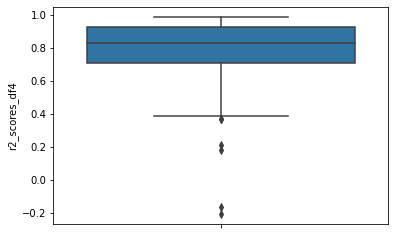

In [15]:
sns.boxplot(y="r2_scores_df4", data = test_df_50);

In [17]:
test_df_50[test_df_50["r2_scores_df4"]<0.6][["param_"+str(i) for i in range(1,5)]]

,param_1,param_2,param_3,param_4
DRUG_ID,,,,
170,0.282951,0.991244,-17.902582,0.001505
170,0.698205,1.048014,-59.845264,0.005641
170,0.249038,1.012518,-39.324919,0.009713
180,0.216242,1.230551,-18.919984,0.223495
180,0.201282,1.083057,-21.678776,0.117393
180,0.239697,1.028090,-25.179452,0.029018
180,0.210689,1.518976,-17.756499,0.367604
180,0.242926,1.251981,-4.968984,0.369870
180,0.256271,1.066051,-28.573456,0.056317
